In [1]:
import math
import yfinance as yf
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
!pip install --upgrade pandas_datareader

In [3]:
data = yf.download('NVDA', start='2020-01-01', end='2024-07-01')

[*********************100%%**********************]  1 of 1 completed


In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,5.96875,5.99775,5.91800,5.99775,5.973632,237536000
2020-01-03,5.87750,5.94575,5.85250,5.90175,5.878019,205384000
2020-01-06,5.80800,5.93175,5.78175,5.92650,5.902669,262636000
2020-01-07,5.95500,6.04425,5.90975,5.99825,5.974131,314856000
2020-01-08,5.99400,6.05100,5.95375,6.00950,5.985336,277108000


In [9]:
data.shape

(1130, 6)

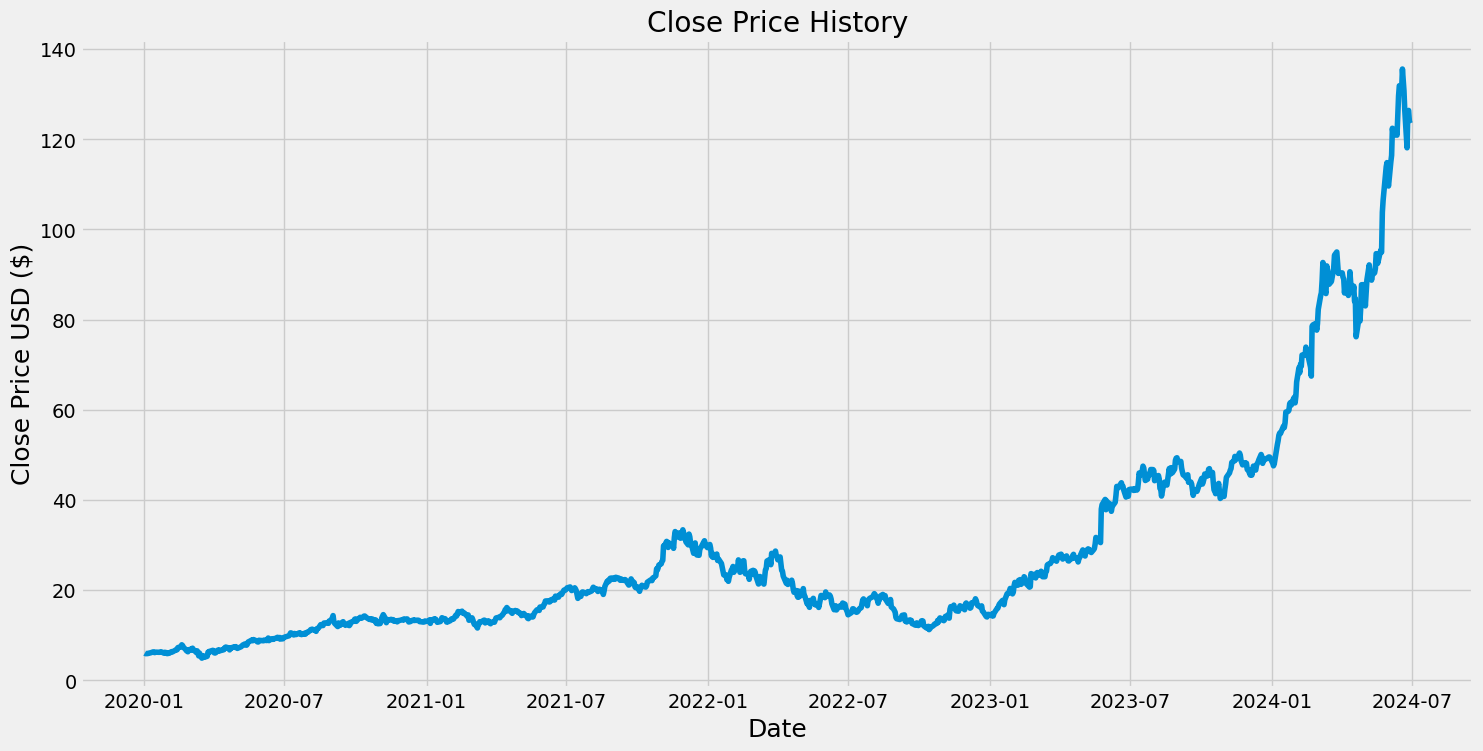

In [11]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [13]:
data1 = data.filter(['Close'])
dataset = data1.values
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

904

In [14]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0083244 ],
       [0.00758973],
       [0.00777914],
       ...,
       [0.92974669],
       [0.91130325],
       [0.90785949]])

In [15]:
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.0083244 , 0.00758973, 0.00777914, 0.00832823, 0.00841433,
       0.00891942, 0.00916813, 0.01063366, 0.00973445, 0.00940729,
       0.01005013, 0.01011709, 0.00986072, 0.01027589, 0.01080202,
       0.01034668, 0.00837989, 0.00986646, 0.00940155, 0.0094532 ,
       0.00765861, 0.00840476, 0.00970575, 0.01040025, 0.01106796,
       0.01055904, 0.01273628, 0.01367758, 0.01456723, 0.0142305 ,
       0.01786753, 0.01916469, 0.02263335, 0.02148542, 0.01868639,
       0.01470881, 0.01256027, 0.01363167, 0.01075228, 0.01409467,
       0.01531147, 0.01329494, 0.01685735, 0.01471072, 0.01332364,
       0.00938242, 0.01237468, 0.00957947, 0.00380922, 0.00850233,
       0.        , 0.00399288, 0.00122829, 0.0031702 , 0.00178886,
       0.00311663, 0.01009796, 0.00941685, 0.01164001, 0.01077715])]
[0.013237545956562548]

[array([0.0083244 , 0.00758973, 0.00777914, 0.00832823, 0.00841433,
       0.00891942, 0.00916813, 0.01063366, 0.00973445, 0.00940729,
       0.01005013, 0.01011709, 0.0

In [18]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train.shape
y_train.shape

(844,)

In [19]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(844, 60, 1)

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

844/844 [==============================] - 27s 27ms/step - loss: 4.0793e-04


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.save('NVDA_stock_price_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
test_data = scaled_data[training_data_len - 60:, :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

In [26]:
x_test = np.array(X_test)
x_test.shape

(226, 60)

In [27]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(226, 60, 1)

In [28]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 2s 16ms/step


In [29]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 12ms/step - loss: 5277.5322


5277.5322265625

In [30]:
rsme = np.sqrt(np.mean(predictions - y_test)**2)
rsme

0.3217847030774682

<ipython-input-31-858541529963>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


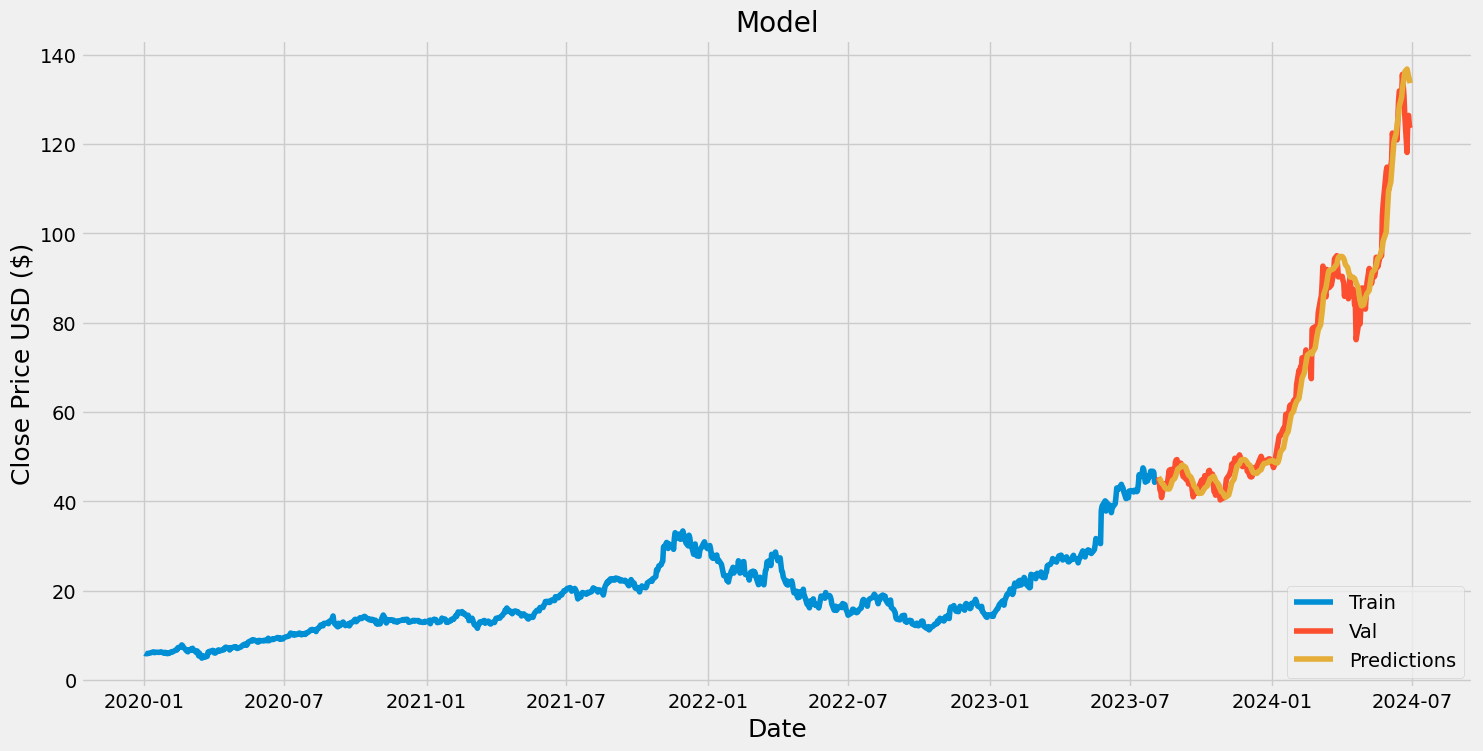

In [31]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
valid

,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2023-08-07,45.111000,45.540001,44.563000,45.417000,45.403404,322154000,45.293140
2023-08-08,44.853001,45.242001,44.056000,44.664001,44.650635,353843000,45.143669
2023-08-09,44.273998,44.312000,42.133999,42.554001,42.541264,586449000,44.977547
2023-08-10,42.160000,43.574001,41.834999,42.388000,42.375313,492705000,44.620102
2023-08-11,41.750999,42.018002,40.639000,40.855000,40.842773,533085000,44.166004
...,...,...,...,...,...,...,...
2024-06-24,123.239998,124.459999,118.040001,118.110001,118.110001,476060900,136.780960
2024-06-25,121.199997,126.500000,119.320000,126.089996,126.089996,425787500,135.884842
2024-06-26,126.129997,128.119995,122.599998,126.400002,126.400002,362975900,135.114517


In [33]:
nvidia_quote = yf.download('NVDA', start='2020-01-01', end='2024-05-31')
new_data = nvidia_quote.filter(['Close'])
last_60_days = new_data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
new_data.shape
new_data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2020-01-02,5.997750
2020-01-03,5.901750
2020-01-06,5.926500
2020-01-07,5.998250
2020-01-08,6.009500
...,...
2024-05-23,103.799004
2024-05-24,106.469002
2024-05-28,113.901001


In [41]:
x_test = []
x_test.append(last_60_days_scaled)
x_test = np.array(x_test)
x_test.shape

(1, 60, 1)

In [42]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(1, 60, 1)

In [45]:
pred_price = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 26ms/step
[[109.407166]]


In [46]:
nvidia_quote2 = yf.download('NVDA', start='2024-05-31', end='2024-06-01')
print(nvidia_quote2['Close'].tail())

[*********************100%%**********************]  1 of 1 completed

Date
2024-05-31    109.633003
Name: Close, dtype: float64


In [48]:
percent = (float(pred_price)/float(nvidia_quote2['Close'].tail()[0]))*100
print(percent)

99.79400572742159


<ipython-input-48-80fcbfc589b6>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  percent = (float(pred_price)/float(nvidia_quote2['Close'].tail()[0]))*100


In [49]:
print("Prediction is correct by "+ str(percent)+" %")

Prediction is correct by 99.79400572742159 %
